In [11]:
# import library
import tensorflow as tf
import numpy as np
import sys, os,cv2
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs,make_moons,make_swiss_roll
from IPython.display  import IFrame

plt.style.use('seaborn')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

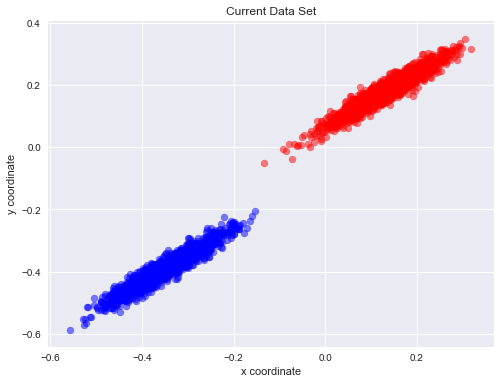

In [12]:
# load some data set
n_samples = 4000
X, y = make_blobs(n_samples=n_samples, random_state=123)
transformation = np.asarray([[3,1],[1,0]])
X = X @ transformation
X = (X - X.min(0,keepdims=True)) / (X.max(0,keepdims=True) - X.min(0,keepdims=True))
X = X - X.mean(0,keepdims=True)
plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('Current Data Set'); plt.ylabel('y coordinate'); plt.xlabel('x coordinate'); plt.grid(True)
plt.show()

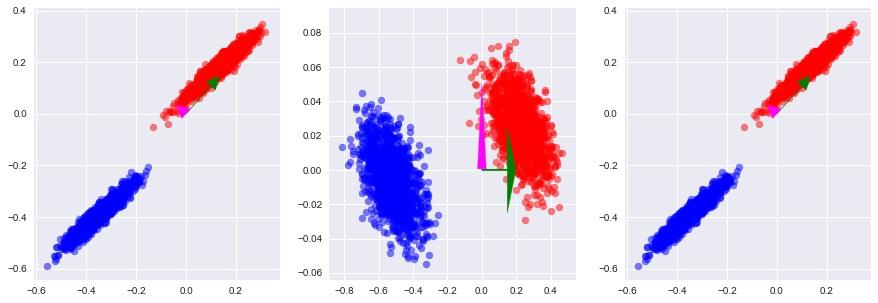

In [21]:
# Do EVD to see the projection matrix
cov        = X.T @ X /(X.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)
idx        = np.argsort(val)[::-1]; val = val[idx]; vec = vec[:,idx]
project_X  = X   @ vec;                      project_V  = vec.T @ vec
revert_X   = project_X @ np.linalg.inv(vec) ;revertedV  = project_V @ np.linalg.inv(vec).T

plt.figure(figsize=(15,5)); 

plt.subplot(131); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(132); 
plt.scatter(project_X[y==0, 0], project_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(project_X[y==1, 0], project_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *project_V[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *project_V[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(133); 
plt.scatter(revert_X[y==0, 0], revert_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(revert_X[y==1, 0], revert_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *revertedV[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *revertedV[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.show()

## Above example is just performing PCA and reconstructing the original data, not that interesting

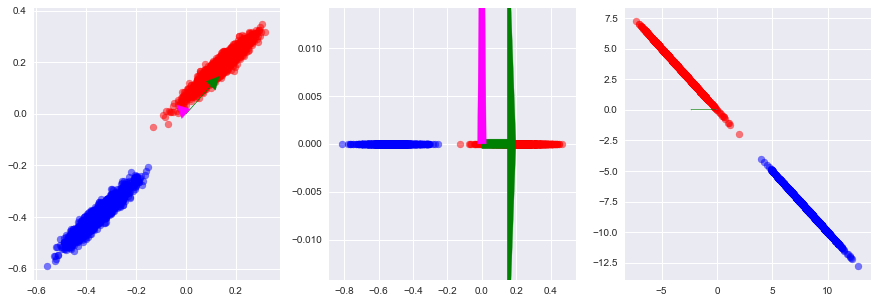

In [14]:
# perform D reduction
cov        = X.T @ X /(X.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)
idx        = np.argsort(val)[::-1]; val = val[idx]; vec = vec[:,idx]

vec_reduced= np.zeros_like(vec)
vec_reduced[:,:1] = vec[:,:1]
val_reduced= val.copy()
val_reduced[-1:]= 0

project_X  = X   @ vec_reduced;                      project_V  = vec_reduced.T @ vec_reduced
revert_X   = project_X @ np.linalg.inv(vec_reduced+0.0001) ;revertedV  = project_V.T @ np.linalg.inv(vec_reduced+0.0001)

plt.figure(figsize=(15,5)); 

plt.subplot(131); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(132); 
plt.scatter(project_X[y==0, 0], project_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(project_X[y==1, 0], project_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *project_V[:,0] * val_reduced[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *project_V[:,1] * val_reduced[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(133); 
plt.scatter(revert_X[y==0, 0], revert_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(revert_X[y==1, 0], revert_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *revertedV[:,0] * val_reduced[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *revertedV[:,1] * val_reduced[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.show()

## Note when we perform dim reduction we lose one pc vector and making the reconstructed data strange and weird

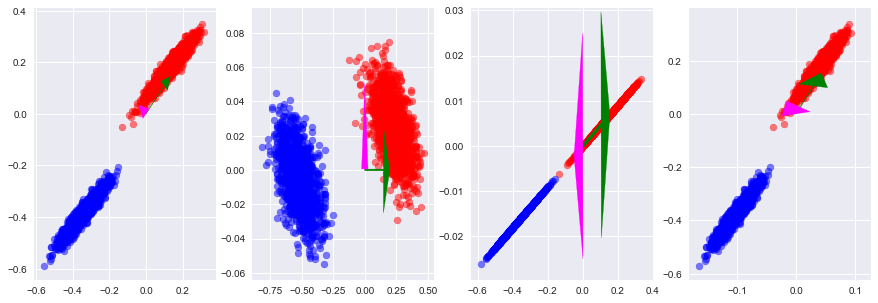

In [15]:
# Do EVD to see the projection matrix
cov        = X.T @ X /(X.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)
idx        = np.argsort(val)[::-1]; val = val[idx]; vec = vec[:,idx]
project_X  = X   @ vec;                      project_V  = vec.T @ vec

plt.figure(figsize=(15,5)); 

plt.subplot(141); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(142); 
plt.scatter(project_X[y==0, 0], project_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(project_X[y==1, 0], project_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *project_V[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *project_V[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

inverse  = np.linalg.inv(vec)
inverse  = inverse - inverse.mean(0,keepdims=True) 
revert_X   = project_X @ inverse ;revertedV  = project_V @ inverse.T

plt.subplot(143); 
plt.scatter(revert_X[y==0, 0], revert_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(revert_X[y==1, 0], revert_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *revertedV[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *revertedV[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

inverse  = np.linalg.inv(vec)
inverse  = inverse - inverse*inverse.std(0,keepdims=True)
revert_X   = project_X @ inverse ;revertedV  = project_V @ inverse.T

plt.subplot(144); 
plt.scatter(revert_X[y==0, 0], revert_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(revert_X[y==1, 0], revert_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *revertedV[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *revertedV[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.show()

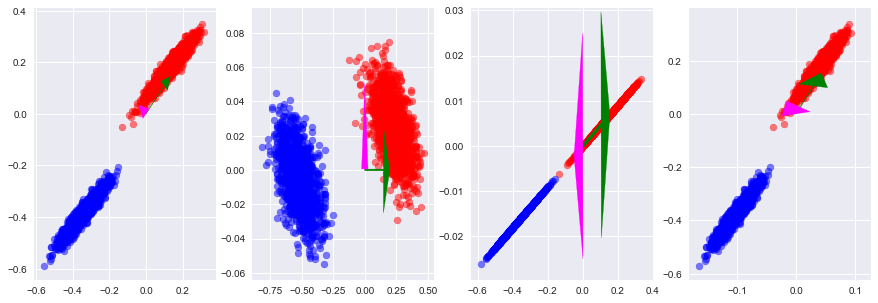

In [33]:
# Do EVD to see the projection matrix
cov        = X.T @ X /(X.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)
idx        = np.argsort(val)[::-1];
val        = val[idx]; 
vec        = vec[:,idx]

project_X  = X     @ vec                     
project_V  = vec.T @ vec

inverse  = np.linalg.inv(vec)
inverse  = inverse - inverse.mean(0,keepdims=True) 
revert_X = project_X @ inverse ;revertedV  = project_V @ inverse.T


plt.figure(figsize=(15,5)); 
plt.subplot(141); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.arrow(0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
plt.arrow(0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')

plt.subplot(142); 
plt.scatter(project_X[y==0, 0], project_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(project_X[y==1, 0], project_X[y==1, 1], color='blue', alpha=0.5)
plt.arrow(0, 0, *project_V[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
plt.arrow(0, 0, *project_V[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')

plt.subplot(143); 
plt.scatter(revert_X[y==0, 0], revert_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(revert_X[y==1, 0], revert_X[y==1, 1], color='blue', alpha=0.5)
plt.arrow(0, 0, *revertedV[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
plt.arrow(0, 0, *revertedV[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')

inverse  = vec.T
inverse  = inverse - inverse*inverse.std(0,keepdims=True)
revert_X = project_X @ inverse ;revertedV  = project_V @ inverse.T

plt.subplot(144); 
plt.scatter(revert_X[y==0, 0], revert_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(revert_X[y==1, 0], revert_X[y==1, 1], color='blue', alpha=0.5)
plt.arrow(0, 0, *revertedV[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
plt.arrow(0, 0, *revertedV[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')

plt.show()

# More Complex looking data we are going to take on
<h> Click <a href='https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py'> here </a> to see more</h>

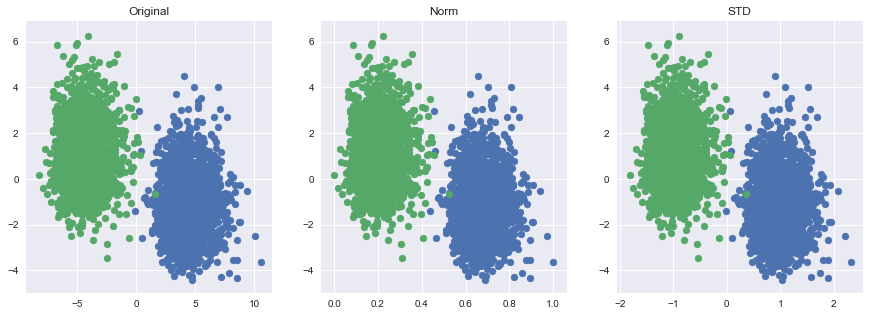

In [116]:
# make circle original data
from sklearn import  datasets
np.random.seed(6789)
data,label  = datasets.make_blobs(n_samples=n_samples,cluster_std=0.9,centers=2)
data = data + np.random.poisson(size=data.shape)
data = data - data.mean(0,keepdims=True)

data_normalized = (data-data.min(0,keepdims=True))/(data.max(0,keepdims=True)-data.min(0,keepdims=True))
data_std        = (data-data.mean(0,keepdims=True))/(data.std(0,keepdims=True))

plt.figure(figsize=(15,5))
plt.subplot(131); plt.scatter(data[label==0,0],data[label==0,1]);           plt.scatter(data[label==1,0],data[label==1,1]); plt.title('Original')
plt.subplot(132); plt.scatter(data_normalized[label==0,0],data[label==0,1]); plt.scatter(data_normalized[label==1,0],data[label==1,1]); plt.title('Norm')
plt.subplot(133); plt.scatter(data_std[label==0,0],data[label==0,1]); plt.scatter(data_std[label==1,0],data[label==1,1]); plt.title('STD')
plt.show()

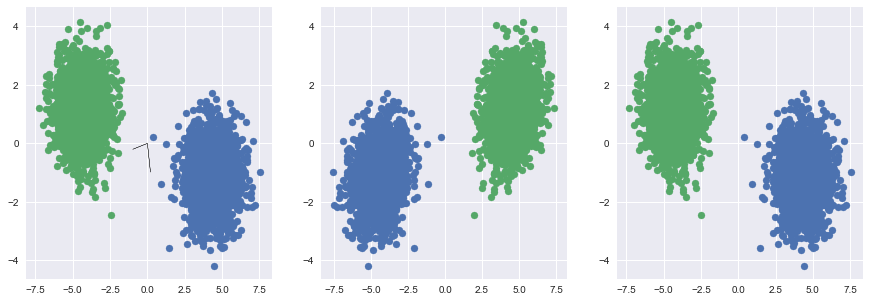

In [102]:
# now fun with pca
cov     = data.T @ data /(data[0]-1) 
val,vec = np.linalg.eigh(cov)
vec     = vec[:,::-1]

projected_data = data @ vec
reconstructdata= projected_data @ vec.T

plt.figure(figsize=(15,5))
plt.subplot(131); 
plt.scatter(data[label==0,0],data[label==0,1]);           plt.scatter(data[label==1,0],data[label==1,1])
plt.arrow(0,0,vec[0,0],vec[0,1]);plt.arrow(0,0,vec[1,0],vec[1,1]);
plt.subplot(132); plt.scatter(projected_data[label==0,0],data[label==0,1]); plt.scatter(projected_data[label==1,0],data[label==1,1])
plt.subplot(133); plt.scatter(reconstructdata[label==0,0],data[label==0,1]); plt.scatter(reconstructdata[label==1,0],data[label==1,1])
plt.show()

In [16]:
IFrame('https://www.youtube.com/embed/hxGF7cPvs_c', width=700, height=350)

In [17]:
IFrame('https://www.youtube.com/embed/6lc6Oz0k9WA', width=700, height=350)

# Good link for robust pca

<a href="https://www.youtube.com/watch?v=hxGF7cPvs_c">one</a>
<a href="https://www.youtube.com/watch?v=DK8RTamIoB8">two</a>
<a href="https://www.youtube.com/watch?v=hxGF7cPvs_c">three</a>
<a href="https://www.youtube.com/watch?v=d0bCO_ECkVo">four</a>
<a href="https://www.youtube.com/watch?v=6lc6Oz0k9WA">five</a>

1. https://www.youtube.com/watch?v=6lc6Oz0k9WA
2. https://www.youtube.com/watch?v=d0bCO_ECkVo
3. https://www.youtube.com/watch?v=hxGF7cPvs_c
4. https://www.youtube.com/watch?v=DK8RTamIoB8
5. https://www.youtube.com/watch?v=hxGF7cPvs_c

# Reference

<br>


1. tf.set_random_seed | TensorFlow. (2018). TensorFlow. Retrieved 28 October 2018, from https://www.tensorflow.org/api_docs/python/tf/set_random_seed
2. Comparing different hierarchical linkage methods on toy datasets — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py
3. VanderPlas, J. (2018). Multiple Subplots | Python Data Science Handbook. Jakevdp.github.io. Retrieved 28 October 2018, from https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
4. object, M. (2018). Matplotlib returning a plot object. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/43925337/matplotlib-returning-a-plot-object
5. Plot randomly generated classification dataset — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html#sphx-glr-auto-examples-datasets-plot-random-dataset-py
6. 5. Dataset loading utilities — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/datasets/index.html
7. mplot3d tutorial — Matplotlib 2.0.2 documentation. (2018). Matplotlib.org. Retrieved 28 October 2018, from https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
8. matplotlib, H. (2018). How to plot vectors in python using matplotlib. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/42281966/how-to-plot-vectors-in-python-using-matplotlib
9. arrow, M. (2018). Matplotlib legend for an arrow. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/22348229/matplotlib-legend-for-an-arrow
10. plt colors - Google Search. (2018). Google.ca. Retrieved 28 October 2018, from https://www.google.ca/search?q=plt+colors&rlz=1C1CHBF_enCA771CA771&oq=plt+colors&aqs=chrome..69i57j0l5.1038j0j7&sourceid=chrome&ie=UTF-8
11. Brownlee, J. (2018). A Gentle Introduction to Singular-Value Decomposition for Machine Learning. Machine Learning Mastery. Retrieved 28 October 2018, from https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
12. https://www.quora.com/Why-do-we-need-to-center-the-data-for-Principle-Components-Analysis
13. ipython-notebook, i. (2018). iframe not rendering in ipython-notebook. Stack Overflow. Retrieved 14 November 2018, from https://stackoverflow.com/questions/17619964/iframe-not-rendering-in-ipython-notebook

In [34]:
! git add .
! git commit -m 'more'
! git push

[master da7671dd] more
 2 files changed, 143 insertions(+), 18 deletions(-)
Counting objects: 7, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 1.00 KiB | 1.00 MiB/s, done.
Total 7 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 3 local objects.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   bca4a363..da7671dd  master -> master
